## W207 Final Project: Predicting Song Success

Instructor: Cornelia Ilin <br>
Team Members: Tyler Chi, Raghav Kaushik, Michael Townsend

---
#### ``Baseline Presentation:``
**1.  What is the question you will be working on? Why is it interesting?** <br>
The question we will be working on is identifying what traits make a song stay on top 200 charts the longest?  Given a set of known features about a song, can we predict if it will land on the top 200 and if so for how long?  This question is interesting because artists could potentially use it to determine the style of songs to write and when to come out with those songs for the highest success.  Factors to study could include Day of the Week, Time of Year (Season), Spotify Song Features, & Artist # of Followers. <br>

**2.  What is the data you will be using? Include data source, size of dataset, main features to be used. Summarize the statistics of your data.** <br>
The data we will be using is Spotify data from 2017 to 2020 from 2 sources on Kaggle:

Spotify Charts: https://www.kaggle.com/datasets/dhruvildave/spotify-charts 
Spotify Artists/Tracks: https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv 

Three Primary Data Sets from these sources:

artists.csv: 1162095 rows, Main Features to be used --> artist name, popularity, and number of followers.  We'd use this file to merge the Artist # of Followers onto the Song Dataset using Artist name to add that metric to our analysis.

charts.csv: 26173514 rows. Main Features to be used --> Date, # of Streams on Top 200, Chart Rank, Time on Chart.  We'd use this file to label the success of each song we study.  

tracks.csv: 586672 rows. this has information that Spotify generated, characterizing various songs with continuous data (loudness, energy, danceability), as well as some discrete data (key, time_signature). To make this data easier to use in our models, we will apply Standardization to all of the continuous parameters.  For the discrete data we will create one-hot encodings.

<br>

**3.  What prediction algorithms do you plan to use? Please describe them in detail.** <br>
We plan to try a mix of classification & regression models to approach this problem.

First, we will use a Feedforward Neural Network to predict whether any song coming out between 2017 and 2021 will land on the top 200.

Second, we will use the data that does hit the top 200 and predict using linear regression & gradient descent how many streams a given song will have while on the top 200.

This will give the artist a way to predict not only what features it takes to get on the chart, but also how to stay on the chart and reach a platinum record status.

For our baseline models we will use just use the Artist # of Followers:

- Artist # of Followers

For our full models we will use the Artist # of Followers along w/ time features along and the Spotify Song Features:

- Artist # of Followers
- Date of Release
- Day of Week of Release
- Time of Year (Season) of Release
- *12 Song Features:* Duration, Danceability, Energy, Loudness, Key, Speechiness, Acoustiness, Instrumentalness, Liveness, Valence, Tempo, Time Signature

Since some of our data is time-based, we plan to perform a non-random split between train and test sets in order to make sure our model is predictive of new data.

The success metrics we will be predicting for the two models will be:

1. Binary Classification --> Top 200 or not?
2. Regression --> # of Streams on Top 200 Charts within X weeks/months of release
<br>

**4. How will you evaluate your results? Please describe your chosen performance metrices and/or statistical tests in detail.** <br>

To evaluate our first Model (Classification using a Feed-Forward Nueral Network) we will use the following:

- Loss, Accuracy, Precision, Recall, Sensitivity, Specificity, F1 Score

We plan to test out different combinations of layers in our neural net (using Keras/Tensorflow) to optimize accuracy on the test dataset.  We'll also assess the other metrics that are typically assessed when evaluating a classification problem.

To evaluate our second Model (Linear Regression) we will use the following:

- Mean Squared Error, R Squared

We plan to use Keras/Tensorflow and run the model at different learning rates to find the optimal mean squared error.

We plan to make comparisons of our baseline model vs. our optimized model for each of the 4 seasons to see if the additional features from the song & time of year make the model more predictive than just using the artist # of followers alone. <br>

---
### Step 1: Import Packages
---

In [1223]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
from datetime import date, timedelta
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

---
### Step 2: Define functions
---

In [1224]:
# determine if a song has appeared in the top 200s
def get_top_200_presence(row):
    track_id = row['id']
    return bool(track_id in top_200_track_id_set)

In [1225]:
# helper method to get number of followers by artist.
def get_followers_by_id_artist(id_artist):
    if id_artist in artist_id_to_followers:
        return artist_id_to_followers[id_artist]
    return 0

In [1226]:
# takes the raw id_artists column, like "['6s1pCNXcbdtQJlsnM1hRIA', '2qGkessPTMJjSEYtxJ11KC', '3rZueITwheLTXxo6uKMdRn']"
# parses out the id's, and returns the total number of followers
def get_total_followers(row):
    id_artist_str = row["id_artists"]
    total_followers = 0
    id_artist_list = id_artist_str[1:-1].replace("'","").replace(" ", "").split(",")
    for id_artist in id_artist_list:
        total_followers += get_followers_by_id_artist(id_artist)
    return total_followers

In [1236]:
def add_30_day_stream_count(tracks_df, top_200_charts_df):
    
    tracks_df = tracks_df[['id', 'release_date']]

    merge_rel_date = pd.merge(top_200_charts_df, tracks_df, left_on='track_id', right_on='id')
    
    merge_rel_date['date'] = pd.to_datetime(merge_rel_date['date'])
    merge_rel_date['release_date'] = pd.to_datetime(merge_rel_date['release_date'])
    merge_rel_date['days_since_release'] = ((merge_rel_date['date'] - merge_rel_date['release_date']) / np.timedelta64(1,'m'))/1440


    merge_rel_date = merge_rel_date.query('days_since_release > 0')
    charts_within_30_days_of_release = merge_rel_date.query('days_since_release <= 30')

    Num_streams_by_ID = charts_within_30_days_of_release.groupby('track_id', as_index=False)['streams'].sum()

    recent_tracks_df_w_streams = pd.merge(recent_tracks_df, Num_streams_by_ID, how='left', left_on='id', right_on='track_id')

    recent_tracks_df_w_streams['log_artist_streams'] = np.log10(recent_tracks_df_w_streams['streams'])
    
    return recent_tracks_df_w_streams

---
### Step 3: Read Data
---

In [1229]:
charts = pd.read_csv('~/W207/W207_Final_Project/Spotify_Charts/charts.csv')
print("Top 200 Charts Data-Set Shape: " + str(charts.shape))
charts.head()

MemoryError: Unable to allocate 512. KiB for an array with shape (65536,) and data type int64

In [1167]:
artists = pd.read_csv('~/W207/W207_Final_Project/Spotify_Tracks/artists.csv')
print("Top 200 Charts Data-Set Shape: " + str(artists.shape))
artists.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [1168]:
tracks = pd.read_csv('~/W207/W207_Final_Project/Spotify_Tracks/tracks.csv')
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


---
### Step 4: Data preprocessing
---

### Step 4.1 Down-Select Tracks & Charts Dataset

Analysis will be done using the Global Top 200 Chart data for 2017, 2018, 2019, and 2020.  This puts all songs on a level playing field in terms of top 200 charts and includes all the years in the dataset that we have all 365 days of chart data for to eliminate any bias from the 2021 partial year of data

In [1336]:
## Parse Tracks file down to last 3 years
tracks['release_date'] = pd.to_datetime(tracks['release_date'])
recent_tracks_df = tracks.query('release_date >= "2017-01-01" & release_date < "2021-01-01"')

## Filter Charts file down to Global & Top 200
top_200_charts = charts.query('chart == "top200" & region == "Global"')

### Step 4.2 Feature Generation:  Top 200 Presence

Will follow the following steps to label each track as on the top 200 or not:

- Extract track_id from url in ```top_200_charts``` data
- Create a set of all the unique IDs that have been in the top 200 over the timeframe
- Apply the ```get_top_200_presence``` function to label each track in the ```recent_tracks_df``` as top 200 if it appeared in the top_200_charts track id set.
- This will be the outcome variable we will predict for our first machine learning model (Classification) which will help artists determine if their song is projected to be on the top 200 or not.

In [1337]:
top_200_charts['track_id'] = top_200_charts.url.apply(lambda x: x.split('/')[-1])

top_200_track_id_set = set()
for track_id in top_200_charts['track_id'].values:
    top_200_track_id_set.add(track_id)
    
recent_tracks_df['top_200_presence'] = recent_tracks_df.apply(get_top_200_presence, axis=1)

<ipython-input-1337-16303e82d5cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_200_charts['track_id'] = top_200_charts.url.apply(lambda x: x.split('/')[-1])
<ipython-input-1337-16303e82d5cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_tracks_df['top_200_presence'] = recent_tracks_df.apply(get_top_200_presence, axis=1)


### Step 4.3 Feature Generation:  # of Followers

Used the following steps to label each track with the total number of followers for the artist of the track:

- Create a list of all artist_ids and the number of followers for each using the ```artists``` dataset
- Apply the ```get_total_followers``` function to take all the artists for a given track and add up the total followers
- Since the ```total_follower_count``` was extremely skewed, also created a ```log_total_follower_count``` to be evaluated as a feature which looks much closer to normal

In [1338]:
# map of artist id to followers
artist_id_to_followers = pd.Series(artists.followers.values, index=artists.id)

<ipython-input-1339-4550b8f2a3e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_tracks_df['total_follower_count'] = recent_tracks_df.apply(get_total_followers, axis=1)


<AxesSubplot:>

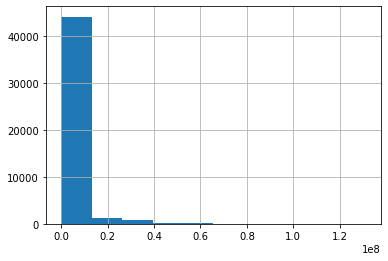

In [1339]:
recent_tracks_df['total_follower_count'] = recent_tracks_df.apply(get_total_followers, axis=1)
recent_tracks_df['total_follower_count'].hist()

<AxesSubplot:>

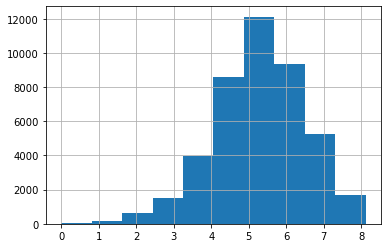

In [1340]:
## Eliminated data w/ no follower count since that's likely an indication there is no data available
recent_tracks_df = recent_tracks_df.query('total_follower_count > 0')
recent_tracks_df['log_total_follower_count'] = np.log10(recent_tracks_df['total_follower_count'])
recent_tracks_df['log_total_follower_count'].hist()

### Step 4.4 Feature Generation:  # of Streams on Top 200 within 30 days of Release Date

Used the following steps to label each track with the total number of followers for the artist of the track:

- Leverge information from ```recent_tracks``` and ```top_200_charts``` to append a count of the # of streams on the Global Top 200 for each song within 30 days of it's release date.
- This will be the outcome variable we will predict for our second machine learning model (Regression) which will help artists determine what is important to stay on the top 200 charts.
- Noticed that streams had an extremely skewed distribution, so we applied a log transform to normalize the outcome.

In [1341]:
recent_tracks_df_w_streams = add_30_day_stream_count(recent_tracks_df, top_200_charts)
recent_tracks_df_w_streams.sort_values('streams')

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,track_id,streams,log_artist_streams
10193,13X0XdLMOdtbXVtAj2ox4h,Besándote,58,181048,0,['Piso 21'],['4bw2Am3p9ji3mYsXNXtQcd'],2017-04-21,0.724,0.8090,7,-4.960,1,0.0560,0.034500,0.000000,0.1690,0.4960,95.037,4,True,6858910.0,6.836255,13X0XdLMOdtbXVtAj2ox4h,453375.0,5.656458
1458,0GVuLQtPXFaL18ijEOqoAa,Tightrope,71,234360,0,['Michelle Williams'],['2LAqcqAQ8KPTsl1HBgBrqM'],2017-12-08,0.351,0.3310,9,-10.316,1,0.0382,0.300000,0.000009,0.0919,0.1910,161.564,3,True,8116.0,3.909342,0GVuLQtPXFaL18ijEOqoAa,461277.0,5.663962
5826,6KuXb26rHuRy3ZDse1VRmx,Where This Flower Blooms (feat. Frank Ocean),69,194933,1,"['Tyler, The Creator', 'Frank Ocean']","['4V8LLVI7PbaPR0K2TGSxFF', '2h93pZq0e7k5yf4dyw...",2017-07-21,0.686,0.4290,8,-10.402,0,0.1500,0.710000,0.000003,0.1660,0.2700,130.090,4,True,13689131.0,7.136376,6KuXb26rHuRy3ZDse1VRmx,465187.0,5.667628
42501,3kdMzXOcrDIdSWLdONHNK5,The Sky Is A Neighborhood,66,244573,0,['Foo Fighters'],['7jy3rLJdDQY21OgRLCZ9sD'],2017-09-15,0.357,0.5490,11,-7.843,0,0.0698,0.000798,0.004850,0.2200,0.5310,130.749,4,True,8658789.0,6.937457,3kdMzXOcrDIdSWLdONHNK5,471591.0,5.673566
5735,6hmhG1b4LEyNuashVvuIAo,Never Forget You,76,213428,0,"['Zara Larsson', 'MNEK']","['1Xylc3o4UrD53lo9CvFvVg', '7uMh23xWiuR7zsNkuN...",2017-03-17,0.583,0.7320,11,-5.728,0,0.0457,0.003120,0.000010,0.2690,0.2760,145.992,4,True,8892301.0,6.949014,6hmhG1b4LEyNuashVvuIAo,473513.0,5.675332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43321,1Kzjk1EyngBcP4T8x3fyqv,同行 (新加坡電視劇《愛...沒有距離》主題曲),43,205238,0,['Boon Hui Lu'],['6PWJWwEm8BSBFAIAUWlwe4'],2020-03-03,0.743,0.6790,8,-3.952,1,0.0323,0.269000,0.000000,0.1330,0.3950,126.070,4,False,36088.0,4.557363,NaN,NaN,NaN
43322,0SjsIzJkZfDU7wlcdklEFR,John Brown's Song,66,185250,0,['Gregory Oberle'],['4MxqhahGRT4BPz1PilXGeu'],2020-03-20,0.562,0.0331,1,-25.551,1,0.1030,0.996000,0.961000,0.1110,0.3860,63.696,3,False,91.0,1.959041,NaN,NaN,NaN
43323,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785000,0.000000,0.0648,0.2110,131.896,4,False,896.0,2.952308,NaN,NaN,NaN
43324,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141000,0.000297,0.0924,0.6860,150.091,4,False,245944.0,5.390836,NaN,NaN,NaN


<AxesSubplot:>

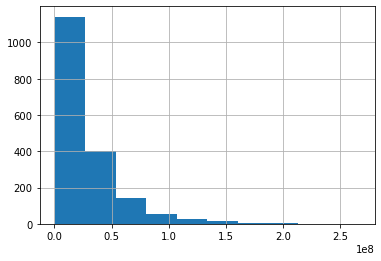

In [1342]:
recent_tracks_df_w_streams['streams'].hist()

<AxesSubplot:>

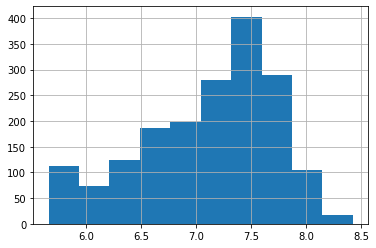

In [1343]:
recent_tracks_df_w_streams['log_artist_streams'].hist()

### Step 4.5 Feature Generation:  EDA of Features to determine Transformations

Used the following steps to explore the data we have and determine what transformations are needed on the features:

- Plotted distributions of each parameter we are thinking about using as input features for our model
- Decided to eliminate songs on the very edge of the speechiness / loudness / song duration distributions to allow for the standardization to work more effectively on those parameters. This only reduced the dataset by 800 songs (2%).
- Decided on the following transforms for the Spotify Music Features based on the distributions:
    - Binary Tranform (Outlier Data driving distribution)
        - Time Signature
        - Instrumentalness
    - One-Hot Encoding (Categorical)
        - Key

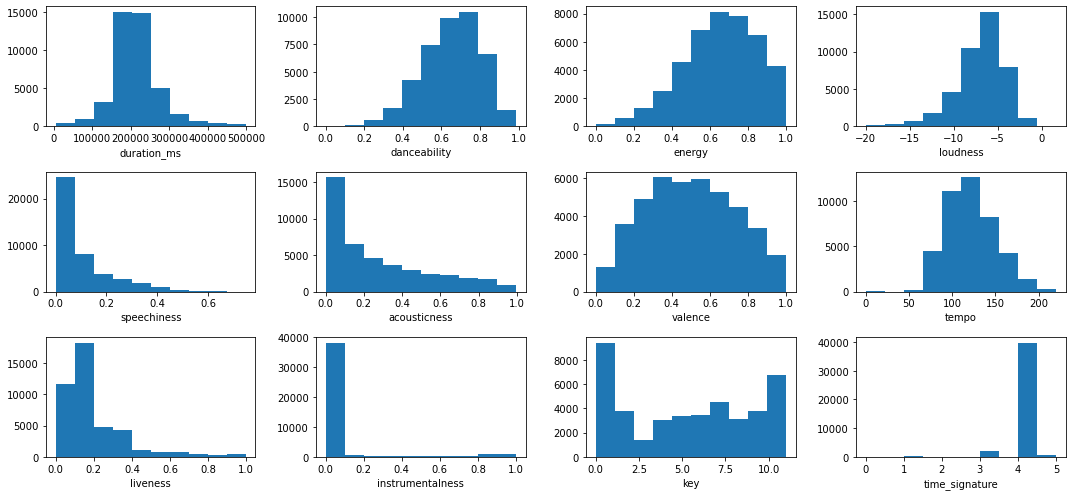

In [1353]:
recent_tracks_df_w_streams = recent_tracks_df_w_streams.query('speechiness < 0.75 & duration_ms < 500000 & loudness > -20')

columns = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'valence', 'tempo', 'liveness', 'instrumentalness', 'key', 'time_signature']
fig1, axes1 = plt.subplots(nrows=3, ncols=4, figsize=(15,7))
for idx, ax in enumerate(axes1.flatten()):
    # plot histogram
    ax.hist(recent_tracks_df_w_streams[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])
plt.tight_layout()

In [1354]:
## Based on initial inspection, applied log / binary transforms to select parameters
recent_tracks_df_w_streams['instrumentalness_binary'] = np.where(recent_tracks_df_w_streams['instrumentalness'] > 0.05, 1, 0)
recent_tracks_df_w_streams['time_sig_binary'] = np.where(recent_tracks_df_w_streams['time_signature'] == 4, 1, 0)

### Step 4.6  Preview of Baseline Regression (Followers vs. Streams)

- Wanted to take a look at how the correlation looked between the Log(Total Artist Followers) and the Log(Streams) as we expect this parameter to have the most predictive power here. It appears as expected there is a correlation between these two parameters

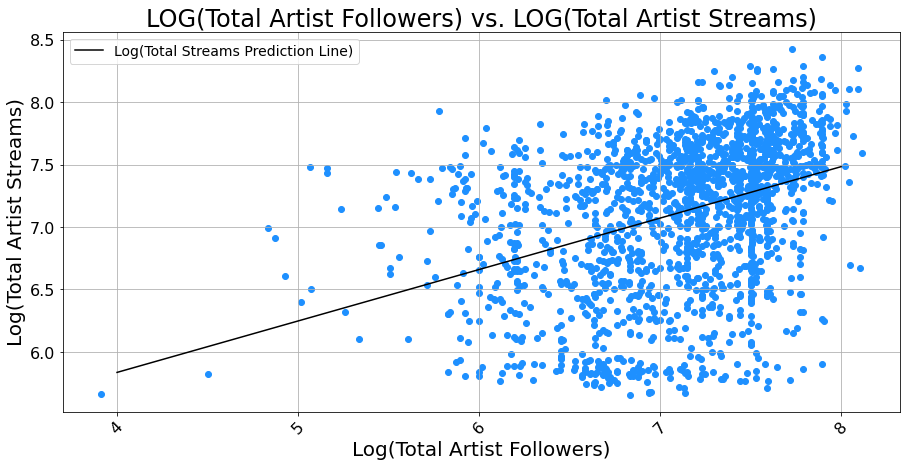

In [1355]:
top_200_recent_tracks_only = recent_tracks_df_w_streams.query('streams > 0')

#a method that lets us make a polynomial model:
regression_line = np.poly1d(np.polyfit(top_200_recent_tracks_only['log_total_follower_count'],top_200_recent_tracks_only['log_artist_streams'],1))
#Then specify how the line will display, we start 
#at position 1, and end at position 22
line_streams = np.linspace(4,8)
plt.figure(figsize=(15,7))
plt.scatter(top_200_recent_tracks_only['log_total_follower_count'], top_200_recent_tracks_only['log_artist_streams'], color='dodgerblue')
plt.plot(line_streams, regression_line(line_streams), color = 'black', label = 'Log(Total Streams Prediction Line)')
plt.title('LOG(Total Artist Followers) vs. LOG(Total Artist Streams)', fontsize=24)
plt.xlabel('Log(Total Artist Followers)', fontsize=20)
plt.ylabel('Log(Total Artist Streams)', fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=16, rotation = 45)
plt.yticks(fontsize=16, rotation = 0)
plt.grid()
plt.show()

### Step 4.7  One-Hot Encodings

- For both of our ML models, we'll want to make our categorical parameters into One-Hot Encodings:
    - Key
    - Month
    - Day of Week
    - Year

#### ``Convert Release date to Datetime & extract month, year, and day of week``

In [1356]:
recent_tracks_df_w_streams['release_date'] = pd.to_datetime(recent_tracks_df_w_streams['release_date'])
recent_tracks_df_w_streams['month_of_release'] = pd.DatetimeIndex(recent_tracks_df_w_streams['release_date']).month
recent_tracks_df_w_streams['year_of_release'] = pd.DatetimeIndex(recent_tracks_df_w_streams['release_date']).year
recent_tracks_df_w_streams['day_of_week_release'] = pd.DatetimeIndex(recent_tracks_df_w_streams['release_date']).dayofweek

#### ``Create one-hot-encodings for Month & Year & Rename Parameters``

In [1357]:
# for year
years = ['2017', '2018', '2019', '2020']
y_d = pd.get_dummies(
    recent_tracks_df_w_streams['year_of_release'],
    prefix='',
    prefix_sep='',
    drop_first = False
) 
y_d = y_d.T.reindex(years).T.fillna(0)

# for months
months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
m_d = pd.get_dummies(
    recent_tracks_df_w_streams['month_of_release'],
    prefix='',
    prefix_sep='',
    drop_first = False
) 
m_d = m_d.T.reindex(months).T.fillna(0)

# join one-hot-encodings
dummies = y_d.join(m_d)

# add to initial df
recent_tracks_df_w_streams = pd.concat(
    [recent_tracks_df_w_streams, dummies],
    axis=1
)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
recent_tracks_df_w_streams.rename(columns = {'1':'m1', '2':'m2', '3':'m3', '4':'m4', '5':'m5', '6':'m6', '7':'m7', '8':'m8', '9':'m9', '10':'m10', '11':'m11', '12':'m12'}, inplace = True)
recent_tracks_df_w_streams.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,track_id,streams,log_artist_streams,instrumentalness_binary,time_sig_binary,month_of_release,year_of_release,day_of_week_release,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.0,0.904,0.239,117.153,3,False,4677919.0,6.670053,NaN,NaN,NaN,0,0,5,2018,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#### ``Create one-hot-encodings for Day of Week & Rename Parameters``

In [1358]:
# for day of week
days = ['0', '1', '2', '3', '4', '5', '6']
doy_of_w_d = pd.get_dummies(
    recent_tracks_df_w_streams['day_of_week_release'],
    prefix='',
    prefix_sep='',
    drop_first = True
) 
dummies = doy_of_w_d.T.reindex(days).T.fillna(0)

# add to initial df
recent_tracks_df_w_streams = pd.concat(
    [recent_tracks_df_w_streams, dummies],
    axis=1
)

recent_tracks_df_w_streams.rename(columns = {'0':'d0','1':'d1', '2':'d2', '3':'d3', '4':'d4', '5':'d5', '6':'d6'}, inplace = True)
recent_tracks_df_w_streams.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,track_id,streams,log_artist_streams,instrumentalness_binary,time_sig_binary,month_of_release,year_of_release,day_of_week_release,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,d0,d1,d2,d3,d4,d5,d6
0,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.0,0.904,0.239,117.153,3,False,4677919.0,6.670053,NaN,NaN,NaN,0,0,5,2018,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### ``Create one-hot-encodings for Key & Rename Parameters``

In [1359]:
# for key
keys = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
key_d = pd.get_dummies(
    recent_tracks_df_w_streams['key'],
    prefix='',
    prefix_sep='',
    drop_first = True
) 
dummies = key_d.T.reindex(keys).T.fillna(0)

# add to initial df
recent_tracks_df_w_streams = pd.concat(
    [recent_tracks_df_w_streams, dummies],
    axis=1
)

recent_tracks_df_w_streams.rename(columns = {'0':'k0','1':'k1', '2':'k2', '3':'k3', '4':'k4', '5':'k5', '6':'k6', '7':'k7', '8':'k8', '9':'k9', '10':'k10', '11':'k11'}, inplace = True)
recent_tracks_df_w_streams.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,track_id,streams,log_artist_streams,instrumentalness_binary,time_sig_binary,month_of_release,year_of_release,day_of_week_release,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,d0,d1,d2,d3,d4,d5,d6,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11
0,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.0,0.904,0.239,117.153,3,False,4677919.0,6.670053,NaN,NaN,NaN,0,0,5,2018,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Step 4.8 Fix Class Imbalance

- As expected, about ~5% of songs in our dataset landed on the top 200. (2305 / 42275 tracks)
- This presents an issue with modeling that we had to address by randomly sampling each group to ensure we have an equal number of True and False labels when we train the model.

In [1360]:
recent_tracks_df_w_streams['top_200_presence'].value_counts()

False    40275
True      2298
Name: top_200_presence, dtype: int64

In [1361]:
# randomly draw 2300 examples from each class
temp_false = recent_tracks_df_w_streams[recent_tracks_df_w_streams['top_200_presence'] == False].sample(
    n=2298,
    replace=False
)

temp_true = recent_tracks_df_w_streams[recent_tracks_df_w_streams['top_200_presence'] == True].sample(
    n=2298,
    replace=False
)

df_balanced = pd.concat(
    [temp_false, temp_true],
    axis=0)

# shuffle df_balanced
df_balanced.sample(frac=1) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data contains', df_balanced.shape[0], 'songs')

After preprocessing, our data contains 4596 songs


In [1362]:
df_balanced['top_200_presence'].value_counts()

True     2298
False    2298
Name: top_200_presence, dtype: int64

In [1363]:
df_balanced['top_200_binary'] = np.where(df_balanced['top_200_presence'] == True, 1, 0)
df_balanced.head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count,track_id,streams,log_artist_streams,instrumentalness_binary,time_sig_binary,month_of_release,year_of_release,day_of_week_release,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,d0,d1,d2,d3,d4,d5,d6,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,top_200_binary
0,6XY80Ofqd8j0SGiEdRLwCp,年少有為,63,279147,0,['Ronghao Li'],['0rTP0x4vRFSDbhtqcCqc8K'],2018-10-17,0.518,0.462,10,-8.471,1,0.0277,0.3220,0.000003,0.1170,0.289,131.892,4,False,339428.0,5.530748,NaN,NaN,NaN,0,1,10,2018,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,782JmkLy6uVD8MW0EJrih9,Quiéreme (feat. Abraham Mateo & Lary Over) - R...,60,256081,0,"['Jacob Forever', 'Farruko', 'Abraham Mateo', ...","['4fCRFHEQgjqakvFgQCliMp', '329e4yvIujISKGKz1B...",2018-01-19,0.528,0.750,2,-4.285,1,0.1090,0.5090,0.000000,0.2770,0.535,175.725,4,False,14573820.0,7.163573,NaN,NaN,NaN,0,1,1,2018,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,6YmRRCqSd6n4Qd3ziRfPSc,Gur Nalo Ishq Mitha - The Yoyo Remake,54,211674,0,"['Yo Yo Honey Singh', 'Malkit Singh']","['7uIbLdzzSEqnX0Pkrb56cR', '79V1EiUrtTyJHQNSKX...",2019-07-24,0.774,0.848,2,-2.712,1,0.0392,0.0299,0.009320,0.0491,0.607,100.027,4,False,5859403.0,6.767853,NaN,NaN,NaN,0,1,7,2019,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,5pddmkNwatcLOEqDqj7xEp,Perrengue - Ao Vivo,60,211483,0,['Gusttavo Lima'],['7MiDcPa6UiV3In7lIM71IN'],2019-10-04,0.826,0.866,0,-1.517,1,0.0355,0.3320,0.000000,0.6650,0.909,123.110,4,False,11880420.0,7.074832,NaN,NaN,NaN,0,1,10,2019,4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4hWZvXVTUYWO3KXThQBwGt,Block Baby,59,208731,1,['kizaru'],['5NipqMGsY4AUeb7kGT8aVz'],2020-11-13,0.710,0.645,4,-6.413,0,0.0396,0.4270,0.000222,0.0393,0.479,119.968,4,False,909417.0,5.958763,NaN,NaN,NaN,0,1,11,2020,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Step 4.9 Split Data Into Train and Test Sets for Baseline & Full Models (Top 200 Classification)

- Will use a 70/30 split between train and test
- For our baseline models we will use just use the Artist # of Followers:
    - Artist # of Followers
- For our full models we will use the Artist # of Followers along w/ time features along and the Spotify Song Features:
    - Artist # of Followers
    - **Time Based** --> Year, Month and Day of Week of Release
    - **Spotify Song Features** --> Duration, Danceability, Energy, Loudness, Key, Speechiness, Acoustiness, Instrumentalness, Liveness, Valence, Tempo, Time Signature

In [1371]:
## BASELINE MODEL - Followers & Time-Based Parameters

# define outcome #
##################
y_base = df_balanced['top_200_binary'].values

# define features #
###################
X_base = df_balanced[['log_total_follower_count']].values

# split #
#########
# set seed for consistent behavior
np.random.seed(1234)

split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X_base, y_base = X_base[shuffle], y_base[shuffle]

splits = np.multiply(len(y_base), split).astype(int) 
X_train_base, X_test_base = np.split(X_base, [splits[0]])
y_train_base, y_test_base = np.split(y_base, [splits[0]])

print('Size of X_train', X_train_base.shape)
print('Size of y_train', y_train_base.shape)
print('Size of X_test', X_test_base.shape)
print('Size of y_test', y_test_base.shape)


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train_base = pd.concat(
    [pd.DataFrame(y_train_base), pd.DataFrame(X_train_base)],
    axis=1
)

# rename columns
df_train_base.columns=['top_200_binary', 'log_total_follower_count']
df_train_base.head(5)

Size of X_train (3217, 1)
Size of y_train (3217,)
Size of X_test (1379, 1)
Size of y_test (1379,)


,top_200_binary,log_total_follower_count
0,0,5.520946
1,1,7.508459
2,0,6.394458
3,0,5.605164
4,1,7.889512


In [1372]:
## Spotify Music Features MODEL - Followers & Time-Based Parameters & Music Features

# define outcome #
##################
y = df_balanced['top_200_binary'].values

# define features #
###################
X = df_balanced[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness_binary', 
        'time_sig_binary', 'liveness', 'valence', 'tempo', 'log_total_follower_count',  '2017', '2018', '2019', '2020', 'm1', 'm2', 'm3', 'm4',
        'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'k0', 'k1', 'k2', 'k3', 'k4', 'k5',
        'k6', 'k7', 'k8', 'k9', 'k10','k11']].values

# split #
#########
# set seed for consistent behavior
np.random.seed(1234)

split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])

print('Size of X_train', X_train.shape)
print('Size of y_train', y_train.shape)
print('Size of X_test', X_test.shape)
print('Size of y_test', y_test.shape)


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['top_200_binary', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness_binary', 
        'time_sig_binary', 'liveness', 'valence', 'tempo', 'log_total_follower_count',  '2017', '2018', '2019', '2020', 'm1', 'm2', 'm3', 'm4',
        'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'k0', 'k1', 'k2', 'k3', 'k4', 'k5',
        'k6', 'k7', 'k8', 'k9', 'k10','k11']
df_train.head(5)

Size of X_train (3217, 47)
Size of y_train (3217,)
Size of X_test (1379, 47)
Size of y_test (1379,)


,top_200_binary,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness_binary,time_sig_binary,liveness,valence,tempo,log_total_follower_count,2017,2018,2019,2020,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,d0,d1,d2,d3,d4,d5,d6,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11
0,0,243057.0,0.651,0.698,-9.894,0.0353,0.0108,1.0,1.0,0.1260,0.0364,119.989,5.520946,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,197968.0,0.743,0.730,-4.314,0.1250,0.2870,0.0,1.0,0.0778,0.1500,179.972,7.508459,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,224693.0,0.698,0.349,-7.579,0.0351,0.8340,0.0,1.0,0.0804,0.4460,121.898,6.394458,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,166947.0,0.583,0.594,-4.848,0.0400,0.5520,0.0,1.0,0.3620,0.4720,84.950,5.605164,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,212500.0,0.842,0.801,-4.167,0.2280,0.1570,0.0,1.0,0.0642,0.6170,95.881,7.889512,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Step 4.10 Apply Standardization to Continous Variables based on Training Set (Top 200 Classification)

In [1373]:
## Split the Training Dataframes for Base / Final Models up by Continuous features & One-Hot Encoding Features.

x_train_df = pd.DataFrame(X_train)
x_train_df.columns = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness_binary', 
        'time_sig_binary', 'liveness', 'valence', 'tempo', 'log_total_follower_count',  '2017', '2018', '2019', '2020', 'm1', 'm2', 'm3', 'm4',
        'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'k0', 'k1', 'k2', 'k3', 'k4', 'k5',
        'k6', 'k7', 'k8', 'k9', 'k10','k11']
x_train_df_cont_features = x_train_df.copy()
x_train_df_cont_features.drop(['2017', '2018', '2019', '2020', 'm1', 'm2', 'm3', 'm4',
        'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'k0', 'k1', 'k2', 'k3', 'k4', 'k5',
        'k6', 'k7', 'k8', 'k9', 'k10','k11', 'time_sig_binary', 'instrumentalness_binary'], axis = 1, inplace = True)
x_train_one_hot_features = x_train_df.copy()
x_train_one_hot_features.drop(['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
       'liveness', 'valence', 'tempo', 'log_total_follower_count'], axis = 1, inplace = True)

In [1374]:
## Split the Test Dataframes for Base / Final Models up by Continuous features & One-Hot Encoding Features.

x_test_df = pd.DataFrame(X_test)
x_test_df.columns = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness_binary', 
        'time_sig_binary', 'liveness', 'valence', 'tempo', 'log_total_follower_count',  '2017', '2018', '2019', '2020', 'm1', 'm2', 'm3', 'm4',
        'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'k0', 'k1', 'k2', 'k3', 'k4', 'k5',
        'k6', 'k7', 'k8', 'k9', 'k10','k11']
x_test_df_cont_features = x_test_df.copy()
x_test_df_cont_features.drop(['2017', '2018', '2019', '2020', 'm1', 'm2', 'm3', 'm4',
        'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'k0', 'k1', 'k2', 'k3', 'k4', 'k5',
        'k6', 'k7', 'k8', 'k9', 'k10','k11', 'time_sig_binary', 'instrumentalness_binary'], axis = 1, inplace = True)
x_test_one_hot_features = x_test_df.copy()
x_test_one_hot_features.drop(['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
       'liveness', 'valence', 'tempo', 'log_total_follower_count'], axis = 1, inplace = True)

In [1375]:
# standardize
sc_x = StandardScaler()

## Apply Standardization to Base + Music Features Model Continuous features and append back to One-Hot Encodings

X_train_cont_features = x_train_df_cont_features.values
X_test_cont_features = x_test_df_cont_features.values

X_train_one_hot_features = x_train_one_hot_features.values
X_test_one_hot_features = x_test_one_hot_features.values

X_train_cont_features_std = sc_x.fit(X_train_cont_features).transform(X_train_cont_features)
X_test_cont_features_std = sc_x.fit(X_train_cont_features).transform(X_test_cont_features)


X_train_std = pd.concat(
    [pd.DataFrame(X_train_cont_features_std), pd.DataFrame(X_train_one_hot_features)],
    axis=1
).values

X_test_std = pd.concat(
    [pd.DataFrame(X_test_cont_features_std), pd.DataFrame(X_test_one_hot_features)],
    axis=1
).values

## Apply Standardization to Baseline Model

X_train_std_base = sc_x.fit(X_train_base).transform(X_train_base)
X_test_std_base = sc_x.fit(X_train_base).transform(X_test_base)

In [1376]:
df_train.isna().sum()

top_200_binary              0
duration_ms                 0
danceability                0
energy                      0
loudness                    0
speechiness                 0
acousticness                0
instrumentalness_binary     0
time_sig_binary             0
liveness                    0
valence                     0
tempo                       0
log_total_follower_count    0
2017                        0
2018                        0
2019                        0
2020                        0
m1                          0
m2                          0
m3                          0
m4                          0
m5                          0
m6                          0
m7                          0
m8                          0
m9                          0
m10                         0
m11                         0
m12                         0
d0                          0
d1                          0
d2                          0
d3                          0
d4        

---
### Step 5: Analysis - Logistical Regression w/ Multiple Features

- Ran two seperate classification models, one for baseline & one w/ a full suite of features to see if the model improves when given information about time of release and type of song.

- For the Full Model, several hyperparameters were tuned to arrive at the final model:
    - Hidden Layers (Amount & Size)
    - Activation Function for hidden layers ('relu' / 'tanh')
    - Optimizer ('Adam' / 'SGD')
    - Drop-Out Layer & Rate
    - Learning Rate
    
- Ultimately, we arrived at a full model w/ 87% Validation & Training Data Accuracy vs. an ~84% baseline model

In [1412]:
def build_model(num_features, hidden_layer_sizes=[], activation='relu', optimizer='SGD', learning_rate=0.01, add_dropout=False):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    

  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                    activation=activation))
        
    
    if add_dropout == True:
            model.add(tf.keras.layers.Dropout(
            rate=0.4))
    
    model.add(keras.layers.Dense(
        units=1,  
        use_bias=True,
        activation='sigmoid',
        #kernel_initializer='random_normal',
        #bias_initializer='zeros'
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Output"
    ))

    if optimizer == 'SGD':
        optimizer_select = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer_select = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
  # Use Binary Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer_select,
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    
    return model

# Build a model
base_model = build_model(1, hidden_layer_sizes=[], activation='relu', optimizer='Adam', learning_rate=0.015, add_dropout=False)
base_model.summary()
model = build_model(47, hidden_layer_sizes=[30,15], activation='relu', optimizer='Adam', learning_rate=0.015, add_dropout=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1440      
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 Output (Dense)              (None, 1)    

In [1413]:
tf.random.set_seed(1234)
np.random.seed(1234)
# Train baseline model
base_hist= base_model.fit(x=X_train_std_base,
                y=y_train_base,
                validation_data=[X_test_std_base, y_test_base],
                validation_split=0.1, # set 10% of train data for validation
                batch_size=len(X_train_std_base),
                epochs=40,
                verbose=1 #silence fit
)

Epoch 1/40
1/1 [==============================] - 0s 406ms/step - loss: 0.6903 - binary_accuracy: 0.5943 - val_loss: 0.6850 - val_binary_accuracy: 0.8426
Epoch 2/40
1/1 [==============================] - 0s 31ms/step - loss: 0.6851 - binary_accuracy: 0.8349 - val_loss: 0.6800 - val_binary_accuracy: 0.8129
Epoch 3/40
1/1 [==============================] - 0s 32ms/step - loss: 0.6801 - binary_accuracy: 0.8287 - val_loss: 0.6750 - val_binary_accuracy: 0.7991
Epoch 4/40
1/1 [==============================] - 0s 29ms/step - loss: 0.6751 - binary_accuracy: 0.8163 - val_loss: 0.6701 - val_binary_accuracy: 0.8209
Epoch 5/40
1/1 [==============================] - 0s 31ms/step - loss: 0.6701 - binary_accuracy: 0.8346 - val_loss: 0.6651 - val_binary_accuracy: 0.8361
Epoch 6/40
1/1 [==============================] - 0s 24ms/step - loss: 0.6652 - binary_accuracy: 0.8349 - val_loss: 0.6601 - val_binary_accuracy: 0.8412
Epoch 7/40
1/1 [==============================] - 0s 24ms/step - loss: 0.6604 - b

In [1415]:
tf.random.set_seed(1234)
np.random.seed(1234)
# Train baseline model
hist= model.fit(x=X_train_std,
                y=y_train,
                validation_data=[X_test_std, y_test],
                validation_split=0.1, # set 10% of train data for validation
                batch_size=len(X_train_std),
                epochs=40,
                verbose=1 #silence fit
)

Epoch 1/40
1/1 [==============================] - 0s 441ms/step - loss: 0.6934 - binary_accuracy: 0.4663 - val_loss: 0.6894 - val_binary_accuracy: 0.6265
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 0.6896 - binary_accuracy: 0.5844 - val_loss: 0.6812 - val_binary_accuracy: 0.7324
Epoch 3/40
1/1 [==============================] - 0s 35ms/step - loss: 0.6814 - binary_accuracy: 0.6764 - val_loss: 0.6671 - val_binary_accuracy: 0.7687
Epoch 4/40
1/1 [==============================] - 0s 35ms/step - loss: 0.6683 - binary_accuracy: 0.7162 - val_loss: 0.6455 - val_binary_accuracy: 0.7636
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6468 - binary_accuracy: 0.7358 - val_loss: 0.6158 - val_binary_accuracy: 0.7716
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6202 - binary_accuracy: 0.7417 - val_loss: 0.5785 - val_binary_accuracy: 0.7759
Epoch 7/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5891 - b

#### ``Plotting Model Performance vs. Baseline``

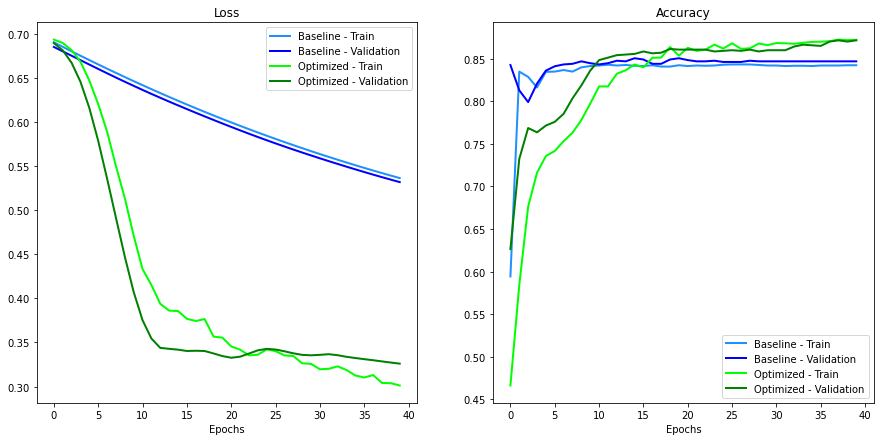

In [1425]:
# grab history
base_history = base_hist.history
history = hist.history

# plot loss for train and validation for baseline vs. optimized
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 2, 1)
plt.plot(base_history['loss'], lw=2, color='dodgerblue', label='Baseline - Train')
plt.plot(base_history['val_loss'], lw=2, color='blue', label = 'Baseline - Validation')
plt.plot(history['loss'], lw=2, color='lime', label='Optimized - Train')
plt.plot(history['val_loss'], lw=2, color='green', label='Optimized - Validation')
plt.legend(fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation for baseline vs. optimized
ax = fig.add_subplot(1, 2, 2)
plt.plot(base_history['binary_accuracy'], lw=2, color='dodgerblue', label='Baseline - Train')
plt.plot(base_history['val_binary_accuracy'], lw=2, color='blue', label = 'Baseline - Validation')
plt.plot(history['binary_accuracy'], lw=2, color='lime', label='Optimized - Train')
plt.plot(history['val_binary_accuracy'], lw=2, color='green', label='Optimized - Validation')
plt.legend(fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

In [1426]:
# run the trained model on the test data (the model outputs probabilities)
y_train_pred_tf = model.predict(x=X_train_std).flatten()
y_train_pred_tf_base = base_model.predict(x=X_train_std_base).flatten()

# apply the threshold function to create a 0, 1 outcome
y_train_pred_tf = np.where(y_train_pred_tf>=0.5, 1, 0)
y_train_pred_tf_base = np.where(y_train_pred_tf_base>=0.5, 1, 0)

101/101 [==============================] - 0s 1ms/step


In [1427]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_tf = model.predict(x=X_test_std).flatten()
y_test_pred_tf_base = base_model.predict(x=X_test_std_base).flatten()

# apply the threshold function to create a 0, 1 outcome
y_test_pred_tf = np.where(y_test_pred_tf>=0.5, 1, 0)
y_test_pred_tf_base = np.where(y_test_pred_tf_base>=0.5, 1, 0)

44/44 [==============================] - 0s 937us/step


In [1419]:
conf_matrix_base = tf.math.confusion_matrix(
    y_test,
    y_test_pred_tf_base,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

conf_matrix = tf.math.confusion_matrix(
    y_test,
    y_test_pred_tf,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

Baseline Confusion Matrix:


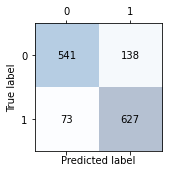

Final Model Confusion Matrix:


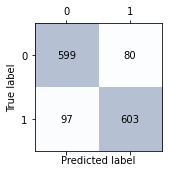

In [1420]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

print('Baseline Confusion Matrix:')
confusion_matrix_plot(conf_matrix_base.numpy())
print('Final Model Confusion Matrix:')
confusion_matrix_plot(conf_matrix.numpy())

In [1421]:
# note that TensorFlow assumes that the positive class is cultivar 1
p_base = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)

p_final = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)

p_base.update_state(y_test, y_test_pred_tf_base)  
p_final.update_state(y_test, y_test_pred_tf)
print("Baseline Precision score: %3f" %p_base.result().numpy())
print("Final Precision score: %3f" %p_final.result().numpy())

Baseline Precision score: 0.819608
Final Precision score: 0.882870


In [1422]:
# note that TensorFlow assumes that the positive class is cultivar 1
r_base = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)

r_final = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)

r_base.update_state(y_test, y_test_pred_tf_base)
r_final.update_state(y_test, y_test_pred_tf)

print("Baseline Recall score: %3f" %r_base.result().numpy())
print("Final Recall score: %3f" %r_final.result().numpy())

Baseline Recall score: 0.895714
Final Recall score: 0.861429


In [1423]:
print("Baseline F1 score:", 2*((p_base.result().numpy()*r_base.result().numpy())/(p_base.result().numpy()+r_base.result().numpy())))
print("Final F1 score:", 2*((p_final.result().numpy()*r_final.result().numpy())/(p_final.result().numpy()+r_final.result().numpy())))

Baseline F1 score: 0.8559726476669312
Final F1 score: 0.8720174431800842
